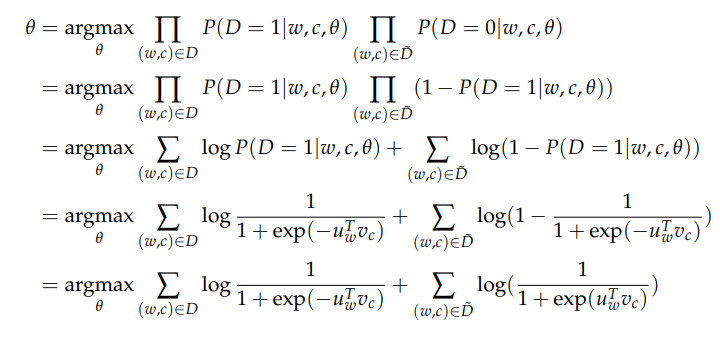

In [ ]:
import torch
import tqdm
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [ ]:
def prepare_sequence(seq, w2i):
    idxs = list(map(lambda w: w2i[w] if w2i.get(w) is not None else w2i["<unk>"], seq))
    return Variable(torch.LongTensor(idxs)).to(device)

def prepare_word(word, w2i):
    return Variable(torch.LongTensor([w2i[word]]) if w2i.get(word) is not None else torch.LongTensor([w2i["<unk>"]])).to(device)

In [ ]:
def get_batch(train_data, batch_size):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size

    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [ ]:
corpus = list(nltk.corpus.gutenberg.sents('melville-moby_dick.txt'))[:500]
corpus = [[word.lower() for word in sent] for sent in corpus]

In [ ]:
corpus[:2], len(corpus)

([['[', 'moby', 'dick', 'by', 'herman', 'melville', '1851', ']'],
  ['etymology', '.']],
 500)

In [ ]:
word_count = Counter(flatten(corpus))
word_count.most_common()[:10], len(word_count)

([(',', 648),
  ('the', 533),
  ('.', 342),
  ('of', 299),
  ('a', 273),
  ('and', 258),
  ('in', 188),
  ('to', 182),
  ('--', 129),
  ('"', 120)],
 2607)

In [ ]:
min_count = 3
exclude = []

for w, c in word_count.items():
    if c < min_count:
        exclude.append(w)

vocab = list(set(flatten(corpus)) - set(exclude))
vocab.append("<unk>")
vocab[:10], len(vocab)

(['green',
  'ishmael',
  'between',
  'account',
  'than',
  'town',
  'over',
  'make',
  'days',
  'jonah'],
 479)

In [ ]:
w2i = {"<unk>": 0}

for v in vocab:
    if w2i.get(v) == None:
        w2i[v] = len(w2i)

i2w = {v: k for k, v in w2i.items()}

In [ ]:
window_size = 5
windows_ = [list(nltk.ngrams(["<dummy>"] * window_size + c + ["<dummy>"] * window_size, window_size * 2 + 1)) for c in corpus]
windows = flatten(windows_)
windows[:5]

[('<dummy>',
  '<dummy>',
  '<dummy>',
  '<dummy>',
  '<dummy>',
  '[',
  'moby',
  'dick',
  'by',
  'herman',
  'melville'),
 ('<dummy>',
  '<dummy>',
  '<dummy>',
  '<dummy>',
  '[',
  'moby',
  'dick',
  'by',
  'herman',
  'melville',
  '1851'),
 ('<dummy>',
  '<dummy>',
  '<dummy>',
  '[',
  'moby',
  'dick',
  'by',
  'herman',
  'melville',
  '1851',
  ']'),
 ('<dummy>',
  '<dummy>',
  '[',
  'moby',
  'dick',
  'by',
  'herman',
  'melville',
  '1851',
  ']',
  '<dummy>'),
 ('<dummy>',
  '[',
  'moby',
  'dick',
  'by',
  'herman',
  'melville',
  '1851',
  ']',
  '<dummy>',
  '<dummy>')]

In [ ]:
train_data = []

for window in windows:
    for i in range(window_size * 2 + 1):
        if window[i] in exclude or window[window_size] in exclude:
            continue

        if i == window_size or window[i] == "<dummy>":
            continue
            
        train_data.append((window[window_size], window[i]))

In [ ]:
train_data[:20], len(train_data)

([('(', 'supplied'),
  ('(', 'by'),
  ('(', 'a'),
  ('(', 'late'),
  ('supplied', '('),
  ('supplied', 'by'),
  ('supplied', 'a'),
  ('supplied', 'late'),
  ('by', '('),
  ('by', 'supplied'),
  ('by', 'a'),
  ('by', 'late'),
  ('by', 'to'),
  ('a', '('),
  ('a', 'supplied'),
  ('a', 'by'),
  ('a', 'late'),
  ('a', 'to'),
  ('a', 'a'),
  ('late', '(')],
 50242)

In [ ]:
X = []
y = []

for d in train_data:
    X.append(prepare_word(d[0], w2i).view(1, -1))
    y.append(prepare_word(d[1], w2i).view(1, -1))

train_data = list(zip(X, y))

In [ ]:
z = 1e-3
num_total_words = sum([c for w, c in word_count.items() if w not in exclude])
unigram_table = []

for v in vocab:
    unigram_table.extend([v] * int((word_count[v] / num_total_words) ** 0.75 / z))

In [ ]:
unigram_table[:10], len(unigram_table)

(['green',
  'green',
  'ishmael',
  'ishmael',
  'ishmael',
  'ishmael',
  'between',
  'between',
  'account',
  'account'],
 3500)

In [ ]:
word = "requires"
word_count[word], (word_count[word] / num_total_words) ** 0.75 / z

(3, 2.746967479045098)

In [ ]:
def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []

    for i in range(batch_size):
        neg_sample = []
        target_idx = targets[i].item()

        while len(neg_sample) < k:
            sample = random.choice(unigram_table)
            if w2i[sample] == target_idx:
                continue
            neg_sample.append(sample)

        neg_samples.append(prepare_sequence(neg_sample, w2i).view(1, -1))
    
    return torch.cat(neg_samples).to(device)

In [ ]:
targets = torch.randn(64)
negs = negative_sampling(targets, unigram_table, 10)

In [ ]:
targets[63], negs[63], negs.shape

(tensor(-0.2902),
 tensor([241, 292, 256, 271, 452, 464,  53, 241, 310, 343], device='cuda:0'),
 torch.Size([64, 10]))

In [ ]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.V = nn.Embedding(vocab_size, embedding_size)
        self.U = nn.Embedding(vocab_size, embedding_size)
        self.logsigmoid = nn.LogSigmoid()

        x = (2.0 / (vocab_size + embedding_size)) ** 0.5
        self.V.weight.data.uniform_(-x, x)
        self.U.weight.data.uniform_(0, 0) 

    def forward(self, center_words, target_words, neg_words):
        center_embeds = self.V(center_words)
        target_embeds = self.U(target_words)
        neg_embeds = -self.U(neg_words)

        postive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        negative_score = torch.sum(neg_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2), 1)
        nll = - torch.mean(self.logsigmoid(postive_score) + self.logsigmoid(negative_score))

        return nll

In [ ]:
epochs = 100
k = 10
batch_size = 64
vocab_size = len(vocab)
embedding_size = 150
lr = 1e-3

In [ ]:
net = Net(vocab_size, embedding_size).to(device)
opt = torch.optim.Adam(net.parameters(), lr)

In [ ]:
def loop(net, batches, k):
    batch_losses = []
    net.train()

    for batch in batches:
        x, y = zip(*batch)

        x = torch.cat(x)
        y = torch.cat(y)
        z = negative_sampling(y, unigram_table, k)
        
        loss = net(x, y, z)
        opt.zero_grad()
        loss.backward()
        opt.step()
        batch_losses.append(loss.item())

    return np.mean(batch_losses)

In [ ]:
for epoch in range(epochs):
    loss = loop(net, get_batch(train_data, batch_size), k)

    if epoch % 10 == 0:
        print(f"epoch: {epoch} | loss: {loss:.4f}")

epoch: 0 | loss: 0.9188
epoch: 10 | loss: 0.6526
epoch: 20 | loss: 0.5615
epoch: 30 | loss: 0.5082
epoch: 40 | loss: 0.4788
epoch: 50 | loss: 0.4620
epoch: 60 | loss: 0.4447
epoch: 70 | loss: 0.4301
epoch: 80 | loss: 0.4326
epoch: 90 | loss: 0.4208


In [ ]:
def get_similar_words(word, vocab):
    v_input = net.V(prepare_word(word, w2i))
    similar_words = []

    for i in range(len(vocab)):
        curr_word = vocab[i]
        if curr_word == word: continue

        v_curr = net.V(prepare_word(curr_word, w2i))
        cosine_sim = F.cosine_similarity(v_input, v_curr)
        similar_words.append([curr_word, cosine_sim.item()])

    return sorted(similar_words, key=lambda x: x[1], reverse=True)[:10]

In [ ]:
random_word = random.choice(vocab)
print(random_word)
get_similar_words(random_word, vocab)

sailor


[['because', 0.6124300956726074],
 ['light', 0.491366982460022],
 ['nigh', 0.4656473398208618],
 ['aloft', 0.45998361706733704],
 ['ha', 0.43159380555152893],
 ['enough', 0.42800629138946533],
 ['city', 0.41277074813842773],
 ['requires', 0.4121016561985016],
 ['commodore', 0.4059513509273529],
 ['myself', 0.4019016921520233]]